## ** CVRPTW resuelto en Gurobi-Python**

#### **Variables de decisión**

- $x_{i,j,k}$ =1 cuando se viaje por el $(i,j)$ con el vehículo k   $\in K$ por lo que el arco es $(i,j,k) \in A$; cero de lo contrario
- $t_{i,k}$ =tiempo en que el vehículo k  $\in K$ llega al nodo i $\in N$

#### **Función Objetivo**
$Min\; z= \; \displaystyle\sum_{i\;\in\;A}^{} \sum_{j\;\in\;A}^{}\sum_{k\;\in\;A}^{} x_{ijk}d_{ij}$

#### **Restricciones**
$\displaystyle\sum_{j\;\in\;C}^{}  x_{0jk}<=1$  $\; \; \forall \;k \; \in \; K$

$\displaystyle\sum_{i\;\in\;C}^{}  x_{i0k}<=1$  $\; \; \forall \;k \; \in \; K$

$\displaystyle\sum_{j\;\in\;N}^{}  x_{ijk}- \sum_{j\;\in\;N}^{} x_{jik}=0$  $\; \; \forall \;k \; \in \; K$

$\displaystyle\sum_{j\;\in\;N}^{}\sum_{k\;\in\;K}^{} x_{ijk}=1$  $\; \; \forall \;i \; \in \; C$

$\displaystyle\sum_{i\;\in\;C}^{}  d_{i} \sum_{j\;\in\;N}^{} x_{ijk}= Q$  $\; \; \forall \;k \; \in \; K$

$t_{ik}+s_{i}+t_{ij}-M*(1-x_{i,j,k})<=t_{jk}$ $\; \; \forall \;k \; \in K$, (i,j) $\in A$ 

$ a_{i}\leq t_{ik} \leq b_{i} $ $\; \; \forall \;k \; \in K$, i $\in A$ 


### **Formulación matemática del problema**
-cliente (C): Conjunto de clientes

-nodos (N) : Conjunto de nodos, donde 0 representa del DC |$\;N= \{0\} \cup C $

-arcos (A´): Conjunto de arcos N x N

-arcosVehiculos (A)= conjuntos de arcos A' x K

-K= Conjunto vehículos disponibles

-$d_{ij}$ = Distancia del nodo i al j

-$t_{ij}$ = Tiempo de viaje del nodo i al j

-$s_{i}$ = Tiempo de servicio en el nodo i

-$q_i$ = Demanda del nodo i

-Q: Capacidad de los vehículos.

-$a_{i}$= Tiempo mínimo de llegada al nodo i

-$b_{i}$= Tiempo máximo de llegada al nodo i

#### Importar librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

#### Parámetros

In [2]:
M=1000 #Valor muy grande
Q = 70 # capacidad de los camiones
clientes=[1, 2, 3, 4, 5, 6]
nodos=[0, 1, 2, 3, 4, 5, 6] #incluye el CD inicial y el de regreso
vehiculos=[1, 2, 3]
q= {1:10, 2:7, 3:13, 4:19, 5:26, 6:30} #demanda

a={0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0} #LBTW
b={0:200, 1:200, 2:200, 3:200, 4:200, 5:200,6:200} #UBTW

s={0:0, 1:10, 2:10, 3:10, 4:10, 5:10, 6:10} #Tiempo de servicio en el nodo i


#### Coordenadas x e y

In [3]:
loc_x=[35,41,35,55,55,15,65]
loc_y=[35,49,17,45,20,30,20]

#### Graficar posición de los nodos

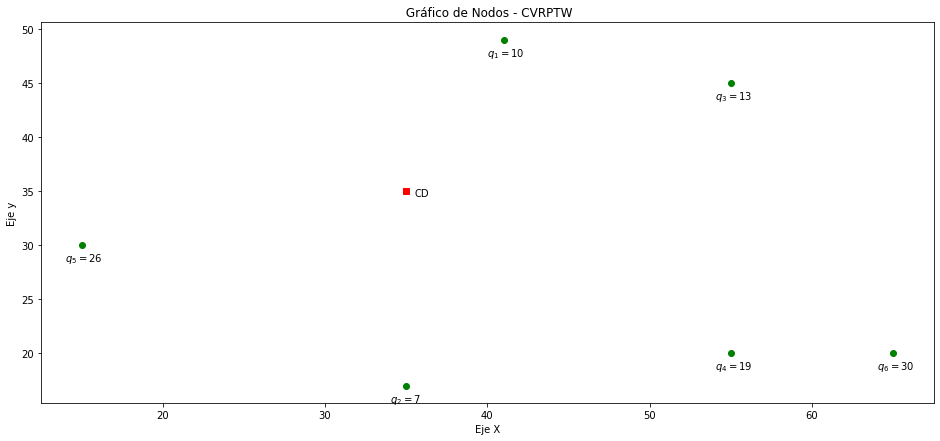

In [4]:
plt.figure(figsize=(16,7)) #tamaño del lienzo donde se grafica
plt.scatter(loc_x,loc_y,c='green') #graficar coordenadas de clientes

for i in clientes:
     plt.annotate('$q_{%d}=%d$'%(i,q[i]),(loc_x[i]-1,loc_y[i]-1.5)) #lo que acompaña al "q" es la demanda de cada cliente

#graficar CD
plt.plot(loc_x[0],loc_y[0],color="red",marker='s') #marker (cuadrado)
plt.annotate('CD',(loc_x[0]+0.5,loc_y[0]-0.5))

#Formato al gráfico
plt.xlabel("Eje X")
plt.ylabel("Eje y")
plt.title(" Gráfico de Nodos - CVRPTW")
plt.show()


#### Estructura de datos

In [5]:
arcos = {(i, j) for i in nodos for j in nodos if i != j} #lista con caminos
arcosVehiculos = {(i, j, k) for i in nodos for j in nodos for k in vehiculos if i != j} 
vehiculosNodos={(k, i) for i in nodos for k in vehiculos} 

distancia = {(i, j): np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j]) for i,j in arcos} # Matriz de distancias
tiempo = {(i, j): distancia[i,j]+ s[i] for i in nodos for j in nodos if i != j}

## Creación y Optimización - CVRPTW ##

#### Crear modelo

In [6]:
mdl=Model('CVRPTW')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-28


#### **Variables de decisión** ####

- $x_{i,j,k}$ =1 cuando se viaje por el $(i,j)$ con el vehículo k   $\in K$ por lo que el arco es $(i,j,k) \in A$; cero de lo contrario
- $t_{i,k}$ =tiempo en que el vehículo k  $\in K$ llega al nodo i $\in N$

In [7]:
x=mdl.addVars(arcosVehiculos,vtype=GRB.BINARY)
t=mdl.addVars(vehiculosNodos,ub=b,lb=a,vtype=GRB.CONTINUOUS) # reemplaza la restricción:ub (upper bound o limite superior) lb (lower bound o limite inferior) 

#### **Función Objetivo** ####
$Min\; z= \; \displaystyle\sum_{i\;\in\;A}^{} \sum_{j\;\in\;A}^{}\sum_{k\;\in\;A}^{} x_{ijk}d_{ij}$

In [8]:
obj=quicksum(distancia[i,j]*x[i,j,k] for i, j, k in arcosVehiculos)
mdl.setObjective(obj,GRB.MINIMIZE)

#### **Restricciones** 
$\displaystyle\sum_{j\;\in\;C}^{}  x_{0jk}<=1$  $\; \; \forall \;k \; \in \; K$

$\displaystyle\sum_{i\;\in\;C}^{}  x_{i0k}<=1$  $\; \; \forall \;k \; \in \; K$

$\displaystyle\sum_{j\;\in\;N}^{}  x_{ijk}- \sum_{j\;\in\;N}^{} x_{jik}=0$  $\; \; \forall \;k \; \in \; K$

$\displaystyle\sum_{j\;\in\;N}^{}\sum_{k\;\in\;K}^{} x_{ijk}=1$  $\; \; \forall \;i \; \in \; C$

$\displaystyle\sum_{i\;\in\;C}^{}  d_{i} \sum_{j\;\in\;N}^{} x_{ijk}= Q$  $\; \; \forall \;k \; \in \; K$

$t_{ik}+s_{i}+t_{ij}-M*(1-x_{i,j,k})<=t_{jk}$ $\; \; \forall \;k \; \in K$, (i,j) $\in A$ 

$ a_{i}\leq t_{ik} \leq b_{i} $ $\; \; \forall \;k \; \in K$, i $\in A$ 

In [9]:
#Salida y llegada al CD
mdl.addConstrs(quicksum(x[0, j, k] for j in clientes if j!= 0) <= 1 for k in vehiculos)
mdl.addConstrs(quicksum(x[i, 0, k] for i in clientes if i!= 0) <= 1 for k in vehiculos)

#Un vehiculo por nodo
mdl.addConstrs(quicksum(x[i, j, k] for j in nodos for k in vehiculos if j != i) == 1 for i in clientes)
mdl.addConstrs(quicksum(x[i, j, k] for k in vehiculos for i in nodos if i != j) == 1 for j in clientes)

#Conservación del flujo
mdl.addConstrs(quicksum(x[i, j, k]- x[j, i, k] for j in nodos if j != i) == 0 for i in clientes for k in vehiculos)

#Capacidad del vehiculo
mdl.addConstrs(quicksum(q[i]*x[i, j, k] for i in clientes for j in nodos if j != i) <= Q for k in vehiculos)

#Ventanas de tiempo
mdl.addConstrs((t[k,i] + s[i]+ tiempo[i,j] - M*(1 - x[i,j,k]) <= t[k,j]) for i in clientes for j in clientes for k in vehiculos if i != j)

#Otra forma de escribir las restricciones de limites:
    #mdl.addConstrs(a[i]<=t[k,i] for i in nodos for k in vehiculos)
    #mdl.addConstrs(t[k,i]<=b[i] for i in nodos for k in vehiculos)


{(1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Upd

#### Optimización y tiempo límite

In [10]:
mdl.Params.TimeLimit = 120  #límite de tiempo (segundos)
mdl.optimize()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 129 rows, 147 columns and 846 nonzeros
Model fingerprint: 0xef386223
Variable types: 21 continuous, 126 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 235.6926210
Presolve removed 0 rows and 3 columns
Presolve time: 0.02s
Presolved: 129 rows, 144 columns, 846 nonzeros
Variable types: 18 continuous, 126 integer (126 binary)

Root relaxation: objective 9.682788e+01, 16 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   96.82788    0   12  235.69262   96.82788  58.9%     -    0s


#### Arcos activos

In [11]:
arcos_activos=[z for z in arcosVehiculos if x[z].x> 0.99] #con el .x se llama a la solución. En cplex es .solution_value 
arcos_activos

[(0, 5, 3),
 (4, 6, 2),
 (5, 1, 3),
 (2, 4, 2),
 (1, 0, 3),
 (0, 2, 2),
 (3, 0, 2),
 (6, 3, 2)]

#### Resultado de la optimización

In [12]:
mdl.objVal

165.55981094285247

#### Graficar posición de los nodos

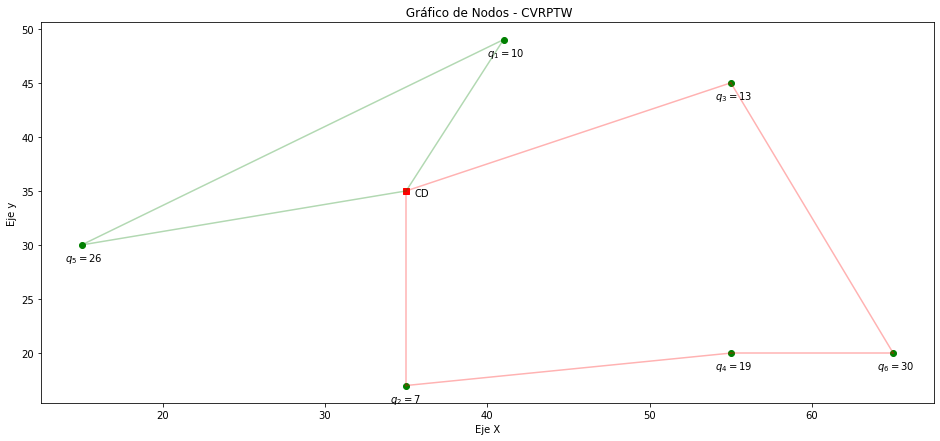

In [13]:
color={1:'blue',2:'red',3:'green'}
plt.figure(figsize=(16,7)) #tamaño del lienzo donde se grafica
plt.scatter(loc_x,loc_y,c='green') #graficar coordenadas de clientes

for i in clientes:
     plt.annotate('$q_{%d}=%d$'%(i,q[i]),(loc_x[i]-1,loc_y[i]-1.5)) #lo que acompaña al "q" es la demanda de cada cliente

#graficar CD
plt.plot(loc_x[0],loc_y[0],color="red",marker='s') #marker (cuadrado)
plt.annotate('CD',(loc_x[0]+0.5,loc_y[0]-0.5))

for i,j,k in arcos_activos:
     plt.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c=color[k],alpha=0.3)

#Formato al gráfico
plt.xlabel("Eje X")
plt.ylabel("Eje y")
plt.title(" Gráfico de Nodos - CVRPTW")
plt.show()
